<a href="https://colab.research.google.com/github/simonetome/ApplieAI-Biomedicine-Masciulli-Pietrobon-Tome/blob/main/DatasetAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this notebook is to show performances augmenting samples of the imbalanced class with random gaussian noise of zero mean and variance 0.05 as suggested in DOI: 10.1155/2020/3215681

In [38]:
!pip install heartpy

In [2]:
import os 
import zipfile 
from scipy.io import loadmat 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import io
from PIL import Image
import tensorflow as tf 
from tensorflow import keras
import sys
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import heartpy as hp

SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [5]:
COLAB = 1

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  cwd = '/content/drive/My Drive/FinalAssignment'
  os.chdir(cwd)
  dataset_folder = os.path.join(cwd,'training_set_dir')
else:
  dataset_current_folder = "training_set.zip" # where the zip is
  dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

  with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
      zip.extractall(dataset_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#IF local runtime used -> Set os.cwd as google drive volume , mounted locally
os.chdir('G:\Il mio Drive')
cwd = os.getcwd()
cwd = os.path.join(cwd,'Colab2022/AppliedAI/FinalAssignment')
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

In [6]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
    label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
    peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
    signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
    if os.path.isfile(label_filepath):
        mat_file = loadmat(label_filepath)
        label = np.asarray(mat_file['labels'])
    if os.path.isfile(peak_filepath):
        mat_file = loadmat(peak_filepath)
        peaks = np.array(mat_file['rpeaks'],dtype=np.int64)
    if os.path.isfile(signal_filepath):
        mat_file = loadmat(signal_filepath)
        signal = np.asarray(mat_file['ecg'] )

    return label, peaks, signal

labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))


In [7]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols

# transform peaks 
for id in tqdm(df.index.tolist()):
    peaks = df.iloc[id]['peaks']
    p_list = list()
    for p in peaks:
        p_list.append(p[0])
    df.iloc[id]['peaks'] = np.asarray(p_list).astype(np.int64)

df.head()

100%|██████████| 105/105 [00:00<00:00, 582.72it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[29, 110, 191, 272, 353, 433, 514, 595, 676, 7...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[48, 153, 243, 352, 440, 547, 636, 742, 831, 9...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[91, 209, 326, 394, 537, 653, 745, 872, 984, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[98, 223, 349, 474, 599, 726, 853, 980, 1116, ...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[27, 127, 225, 324, 423, 523, 623, 722, 822, 9...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [120]:
# upsampling the signal 

from scipy.signal import resample

ids_128 = df[df['frequencies'] == 128].index.tolist() 
ids_250 = df[df['frequencies'] == 250].index.tolist() 
resampled_len =  len(df.iloc[ids_250[0]]['ecg_lead_1'])
sampled_len = len(df.iloc[ids_128[0]]['ecg_lead_1'])

for id in tqdm(ids_128):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/sampled_len)

df.head()

100%|██████████| 65/65 [00:18<00:00,  3.44it/s]


,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S001,"[-3.3908420959960495e-08, 0.011314918287098408...","[0.08000000566244125, 0.08619667589664459, 0.0...","[56, 214, 373, 531, 689, 845, 1003, 1162, 1320...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
1,S002,"[-0.034999970346689224, -0.04483037441968918, ...","[-0.0950000062584877, -0.109402135014534, -0.1...","[93, 298, 474, 687, 859, 1068, 1242, 1449, 162...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
2,S003,"[-0.5600001215934753, -0.57822585105896, -0.56...","[0.4300000071525574, 0.4723737835884094, 0.564...","[177, 408, 636, 769, 1048, 1275, 1455, 1703, 1...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
3,S004,"[-0.460000216960907, -0.47652408480644226, -0....","[0.5600000023841858, 0.6865580081939697, 0.605...","[191, 435, 681, 925, 1169, 1417, 1666, 1914, 2...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
4,S005,"[-0.27000004053115845, -0.5269216299057007, -0...","[-0.019999966025352478, 0.03706035017967224, -...","[52, 248, 439, 632, 826, 1021, 1216, 1410, 160...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [8]:
# because of the curse of dimensionality --> undersampling 

from scipy.signal import resample

ids_128 = df[df['frequencies'] == 128].index.tolist() # 65 signals are sampled using fs = 128
ids_250 = df[df['frequencies'] == 250].index.tolist() # 65 signals are sampled using fs = 128
sampled_len =  len(df.iloc[ids_250[0]]['ecg_lead_1'])
resampled_len = len(df.iloc[ids_128[0]]['ecg_lead_1'])

for id in tqdm(ids_250):
    row = df.iloc[id]
    # first lead
    signal = np.asarray(row['ecg_lead_1']).astype(np.float32)
    resampled_1 = resample(signal,resampled_len)
    
    # second lead
    
    signal = np.asarray(row['ecg_lead_2']).astype(np.float32)
    resampled_2 = resample(signal,resampled_len)
    
    df.iloc[id]['ecg_lead_1'] = resampled_1.tolist()
    df.iloc[id]['ecg_lead_2'] = resampled_2.tolist()
    
    for i,p in enumerate(list(df.iloc[id]['peaks'])):
        df.iloc[id]['peaks'][i] = int(resampled_len * p/sampled_len)


100%|██████████| 40/40 [00:11<00:00,  3.55it/s]


In [9]:
# analysis of RR distance RR[1] = distance between peak 1 and peak 0 (not defined for the first peak)
# do that for each signal and check significative differences for each peak label 

signal_ids = df.index.tolist()
RR_dict = {}

for id_ in tqdm(signal_ids):  
  sig_Id = df.iloc[id_]['sigId']
  RR_dict[sig_Id] = {}
  RR_dict[sig_Id]['RR_distances'] = list()
  RR_dict[sig_Id]['S_distances'] = list()
  
  peaks = df.iloc[id_]['peaks']
  labels = df.iloc[id_]['labels']

  for i,p in enumerate(peaks[1:-1]):
    RR_distance = p-peaks[i]
    if(RR_distance < 250): # discard outliers
      RR_dict[sig_Id]['RR_distances'].append(RR_distance)
      if(labels[i+1] == 'S'):
        RR_dict[sig_Id]['S_distances'].append(RR_distance)

  RR_dict[sig_Id]['RR_distances'] = np.asarray(RR_dict[sig_Id]['RR_distances'])
  RR_dict[sig_Id]['S_distances'] = np.asarray(RR_dict[sig_Id]['S_distances'])

  RR_dict[sig_Id]['Avg_RR_distance'] = RR_dict[sig_Id]['RR_distances'].mean()
  RR_dict[sig_Id]['AVG_S_distance'] = RR_dict[sig_Id]['S_distances'].mean()


RR_df = pd.DataFrame.from_dict(RR_dict,orient="index")
RR_df.tail()

100%|██████████| 105/105 [00:00<00:00, 163.37it/s]


,RR_distances,S_distances,Avg_RR_distance,AVG_S_distance
S114,"[117, 116, 115, 112, 113, 114, 114, 112, 116, ...",[],114.914745,NaN
S115,"[113, 118, 80, 151, 118, 123, 76, 152, 119, 11...",[73],89.041006,73.000000
S116,"[143, 145, 141, 146, 143, 142, 144, 142, 143, ...",[75],122.611082,75.000000
S117,"[142, 143, 147, 148, 145, 139, 148, 139, 140, ...","[119, 99, 92, 100, 99, 92, 91, 92, 89, 87, 82,...",106.363048,83.558719
S118,"[85, 84, 86, 81, 82, 85, 81, 83, 83, 82, 84, 8...",[],93.967755,NaN


# plot distribution for the RR distances using 250 Hz upsampling

In [ ]:
print(max(RR_df['Avg_RR_distance'])/250)
print(min(RR_df['Avg_RR_distance'])/250)

0.9477777777777778
0.42275657894736846


'\nfolder = "C://Users//simon//Desktop//figures"\nname = "RR_distribution.png"\n\nplt.savefig(os.path.join(folder,name), format=\'png\',pad_inches=0.1,\n        facecolor=\'auto\', edgecolor=\'auto\',\n       )\n'

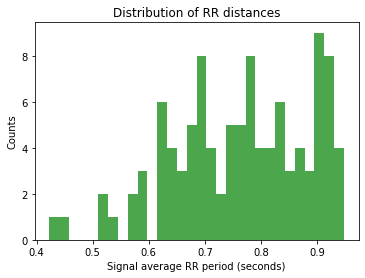

In [123]:
import seaborn as sns 
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

def to_seconds(samples):
  fs = 250
  return samples/fs

avg_rrs = RR_df['Avg_RR_distance'].values.tolist()

for i,rr in enumerate(avg_rrs):
  avg_rrs[i] = to_seconds(rr)

num_bins = 30
n, bins, patches = plt.hist(avg_rrs, num_bins,facecolor='green', alpha=0.7)
plt.title(r'Distribution of RR distances')
plt.xlabel('Signal average RR period (seconds)')
plt.ylabel('Counts')
plt.subplots_adjust(left=0.15)
#plt.show()

'''
folder = "C://Users//simon//Desktop//figures"
name = "RR_distribution.png"

plt.savefig(os.path.join(folder,name), format='png',pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
       )
'''


# Amplitude analysis 

In [ ]:
first_leads = list()
second_leads = list()

for id in df.index.tolist():
  row = df.iloc[id]
  first_leads += row['ecg_lead_1']
  second_leads += row['ecg_lead_2']  




In [ ]:
num_bins = 40
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6),sharey='all')
ax1.hist(first_leads, num_bins,facecolor='green', alpha=0.6)
ax2.hist(second_leads, num_bins,facecolor='blue', alpha=0.6)
ax1.set_xlabel('Samples amplitudes first lead')
ax2.set_xlabel('Samples amplitudes second lead')
ax1.set_ylabel('Counts')
plt.subplots_adjust(left=0.15)
plt.show()

'''
folder = "C://Users//simon//Desktop//figures"
name = "amplitudes.png"

plt.savefig(os.path.join(folder,name), format='png',pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
       )

'''

#Class unbalance problem 

N: 226932
S: 9609
V: 7795


'\nfolder = "C://Users//simon//Desktop//figures"\nname = "unbalance.png"\n\nplt.savefig(os.path.join(folder,name), format=\'png\',pad_inches=0.1,\n        facecolor=\'auto\', edgecolor=\'auto\',\n       )\n'

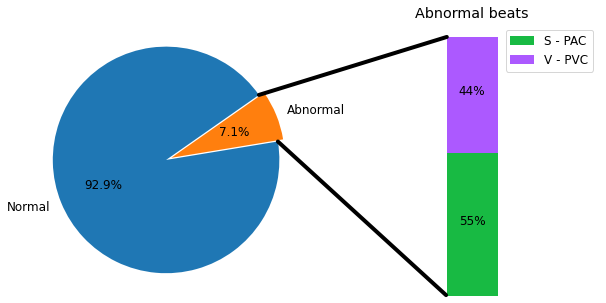

In [13]:
from matplotlib.patches import ConnectionPatch

font = {'family' : 'normal',
        'size'   : 12}
#'weight' : 'bold',
plt.rc('font', **font)


pielabels = ["Normal", "Abnormal"]
classes = ["N","S","V"]
counts = [0,0,0]

for id in df.index.tolist():
  row = df.iloc[id]
  labels = row['labels']
  for l in labels:
    counts[classes.index(l)] += 1

print(f"N: {counts[0]}")
print(f"S: {counts[1]}")
print(f"V: {counts[2]}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
explode = (0.05 , 0)

ax1.pie([counts[0],counts[1]+counts[2]], explode=explode, labels=pielabels, autopct='%1.1f%%',
        shadow=False, startangle = 35)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.






xpos = 0
bottom = 0

total_anormal = counts[1]+counts[2]
ratios = [counts[1]/total_anormal, counts[2]/total_anormal]

width = .2
colors = [[24/255, 186/255, 67/255], [172/255, 89/255, 255/255]]




for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.set_title('Abnormal beats')
ax2.legend(('S - PAC','V - PVC'))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta2, theta1 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData,shrinkA=1)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

fig.set_facecolor("white")

'''
folder = "C://Users//simon//Desktop//figures"
name = "unbalance.png"

plt.savefig(os.path.join(folder,name), format='png',pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
       )
'''

In [ ]:
resampled_len / 250


1800.0

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


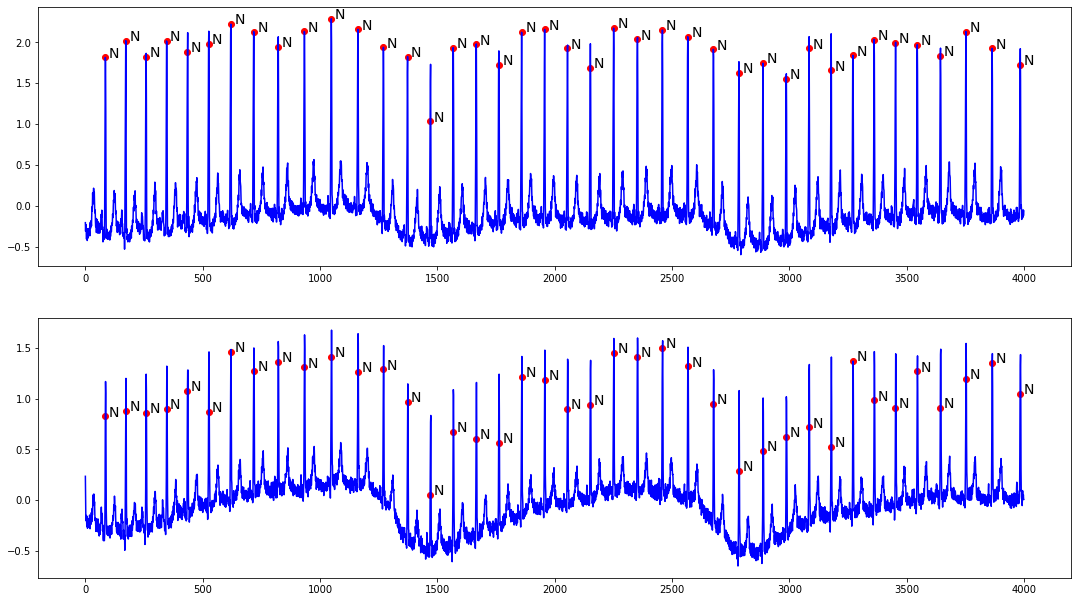

In [10]:
# plot signal 
from scipy.fft import fft, fftfreq

def plot_signal(df,id,length):
    fig,axs = plt.subplots(2)
    fig.set_size_inches(18.5, 10.5)
    ax1 = axs[0]
    ax2 = axs[1]
    
    
    signal = df.iloc[id]
    
    first_lead = signal['ecg_lead_1'][:length]
    second_lead = signal['ecg_lead_2'][:length]
    
    peaks_ = signal['peaks']
    labels_ = signal['labels']
    
    x = list(range(length))
    
   # for i in range(len(first_lead)):
    #    first_lead[i] *= -1
    #    second_lead[i] *= -1
    
    ax1.plot(x,first_lead,color='blue')
    ax2.plot(x,second_lead,color='blue')
    
    peaks = list()
    p_amplitudes_first = list()
    p_amplitudes_second = list()
    labels = list()
    
    for i,p in enumerate(peaks_):
        if(p <= length):
            peaks.append(p)
            p_amplitudes_first.append(first_lead[p])
            p_amplitudes_second.append(second_lead[p])
            labels.append(labels_[i])
        else:
            break
            
    ax1.scatter(peaks,p_amplitudes_first,color='red')
    # peak at 0.0625 Hz 
    N = length
    T = 1.0 / 250.0
    x = np.linspace(0.0, N*T, N, endpoint=False)
    x_ = list(range(length))
    y = np.sin(0.0625 * 2.0*np.pi*x) 
    
    #ax2.plot(x_,y,color='green')
    ax2.scatter(peaks,p_amplitudes_second,color='red')
    offset = 15
    
    for i, txt in enumerate(labels):
        ax1.annotate(txt, (peaks[i]+offset, p_amplitudes_first[i]),size = 14)
        ax2.annotate(txt, (peaks[i]+offset, p_amplitudes_second[i]),size = 14)
    
    print(labels)
    plt.show()

plot_signal(df,70,4000)

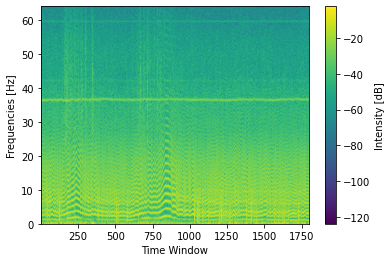

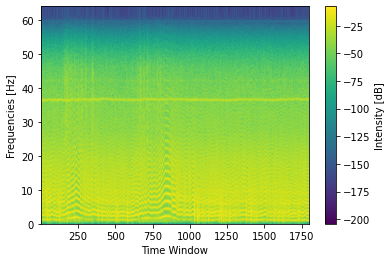

In [12]:
from scipy.signal import resample, butter, lfilter, iirnotch

def notch_filter(cutoff, fs, q=30):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

#def bandpass_filter(data, filter_order=5, lowcut = .5, highcut = 55, signal_freq=128):
def bandpass_filter(data, filter_order=6, lowcut = 0.8, highcut = 45, signal_freq=128):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        powerline = 60
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data,zi = None)
        #b,a = notch_filter(powerline,signal_freq)
        #y = lfilter(b,a,y)
        return y


fs = 128.0
t = np.arange(0,10,1/fs)
x = df.iloc[70]['ecg_lead_1']#[:8000]
#print(df.iloc[21]['sigId'])
fig,ax = plt.subplots()
ax.set_xlabel('Time Window')
ax.set_ylabel('Frequencies [Hz]')
pxx,  freq, t, cax = ax.specgram(x, NFFT=512, Fs=fs)
fig.colorbar(cax).set_label('Intensity [dB]')
plt.show()


fs = 128.0
t = np.arange(0,10,1/fs)
x = bandpass_filter(df.iloc[70]['ecg_lead_1'])#[:8000])
fig,ax = plt.subplots()
ax.set_xlabel('Time Window')
ax.set_ylabel('Frequencies [Hz]')
pxx,  freq, t, cax = ax.specgram(x, NFFT=512, Fs=fs)
fig.colorbar(cax).set_label('Intensity [dB]')
plt.show()


In [ ]:
# Number of sample points
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6),sharey='all')

y = df.iloc[0]['ecg_lead_2'][:4000]
N = len(y)
fs = 250.
T = 1.0 / fs
x = np.linspace(0.0, N*T, N, endpoint=False)

yf = fft(y)
xf = fftfreq(N, T)[:N//2]

ax1.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax1.grid()

y = df.iloc[70]['ecg_lead_2'][:4000]
N = len(y)
fs = 250.
T = 1.0 / fs
x = np.linspace(0.0, N*T, N, endpoint=False)

yf = fft(y)
xf = fftfreq(N, T)[:N//2]

ax2.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax2.grid()

print(xf[:30])
print(2.0/N * np.abs(yf[0:N//2])[:30])

ax1.set_xlabel("frequencies [Hz]")
ax2.set_xlabel("frequencies [Hz]")

folder = "C://Users//simon//Desktop//figures"
name = "fft.png"

plt.savefig(os.path.join(folder,name), format='png',pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
       )

In [ ]:
fig,ax1 = plt.subplots(figsize=(6, 4),sharey='all')

y = df.iloc[70]['ecg_lead_2'][:4000]
N = len(y)
fs = 250.
T = 1.0 / fs
x = np.linspace(0.0, N*T, N, endpoint=False)

yf = fft(y)
xf = fftfreq(N, T)[:N//2]

ax1.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax1.grid()


ax1.set_xlabel("frequencies [Hz]")

folder = "C://Users//simon//Desktop//figures"
name = "fft_lead2.png"

plt.savefig(os.path.join(folder,name), format='png',pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
       )

['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


'\nfolder = "C://Users//simon//Desktop//figures"\nname = "lead2_signal.png"\n\nplt.savefig(os.path.join(folder,name), format=\'png\',pad_inches=0.1,\n        facecolor=\'white\', edgecolor=\'white\',\n       )\n'

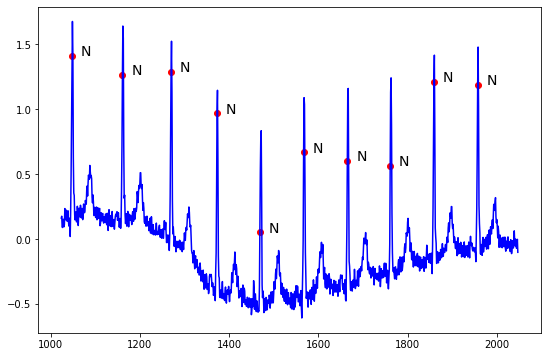

In [13]:
# plot signal 
from scipy.fft import fft, fftfreq

def plot_signal(df,id,starting,length, title = ''):
    fig,ax1 = plt.subplots()
    fig.set_size_inches(9, 6)
    ax1.set_title(title)
    
    signal = df.iloc[id]
    
    first_lead = signal['ecg_lead_1'][starting:length]
    second_lead = signal['ecg_lead_2'][starting:length]
    
    peaks_ = signal['peaks']
    labels_ = signal['labels']
    
    x = list(range(starting,length))
    ax1.plot(x,second_lead,color='blue')
    
    
    peaks = list()
    p_amplitudes_second = list()
    labels = list()
    
    for i,p in enumerate(peaks_):
        if(p <= length and p >= starting):
            peaks.append(p)
            p_amplitudes_second.append(signal['ecg_lead_2'][p])
            labels.append(signal['labels'][i])
            
    ax1.scatter(peaks,p_amplitudes_second,color='red')
    # peak at 0.0625 Hz 
    N = length
    T = 1.0 / 250.0
    x = np.linspace(0.0, N*T, N, endpoint=False)
    x_ = list(range(length))
    y = np.sin(0.0625 * 2.0*np.pi*x) 
    
    #ax2.plot(x_,y,color='green')
    
    offset = 20 
    
    for i, txt in enumerate(labels):
        ax1.annotate(txt, (peaks[i]+offset, p_amplitudes_second[i]),size = 14)
       
    print(labels)
    #plt.show()

plot_signal(df,70,1024,2048)

'''
folder = "C://Users//simon//Desktop//figures"
name = "lead2_signal.png"

plt.savefig(os.path.join(folder,name), format='png',pad_inches=0.1,
        facecolor='white', edgecolor='white',
       )
'''

100%|██████████| 105/105 [00:03<00:00, 27.49it/s]


['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


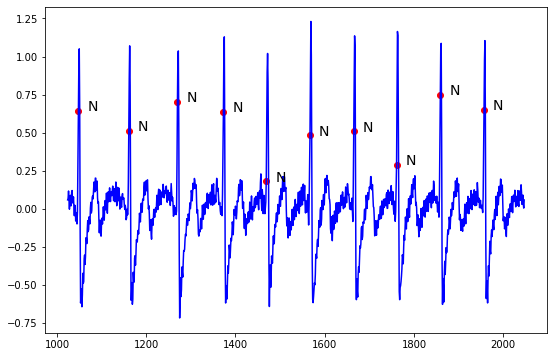

In [14]:
filtered_df = df.copy(deep= True)

ids = filtered_df.index.tolist()

for id_ in tqdm(ids):
    
    row = filtered_df.iloc[id_]
    first = row['ecg_lead_1']
    second = row['ecg_lead_2']
    filtered_first = np.asarray(bandpass_filter(first))
    filtered_second =  np.asarray(bandpass_filter(second))

    #filtered_first = hp.smooth_signal(filtered_first, 128)
    #filtered_second = hp.smooth_signal(filtered_second, 128)

    filtered_df.iloc[id_]['ecg_lead_1'] = pd.Series(filtered_first)
    filtered_df.iloc[id_]['ecg_lead_2'] = pd.Series(filtered_second)

plot_signal(filtered_df,70,1024,2048)

In [15]:
import heartpy as hp 

classes = np.array(["N","S","V"])

patch_length = 350 

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)

def create_patch_dataset(df):
    
    dataset_dict = {}
    ids = df['sigId']
   
    for id in tqdm(ids):
        row = df[df['sigId'] == id]
        sigId = row['sigId'].values[0]
        peaks = row['peaks'].values[0]
        first_lead_signal = row['ecg_lead_1'].values[0]
        second_lead_signal = row['ecg_lead_2'].values[0]
        labels = row['labels'].values[0]
        avg_RR = RR_df.loc[sigId]['Avg_RR_distance'] # T for the signal 

        for i,peak in enumerate(peaks):
            
            stringIdx = str(sigId)+'_'+str(i)    
            dataset_dict[stringIdx] = {}
            dataset_dict[stringIdx]["first_lead"] = list()
            dataset_dict[stringIdx]["second_lead"] = list()
            size = list(range(int(peak-(avg_RR)),int(peak+avg_RR)))

            for s in size:
                if(s < 0 or s >= len(first_lead_signal)):
                    dataset_dict[stringIdx]["first_lead"].append(0.5)
                    dataset_dict[stringIdx]["second_lead"].append(0.5)
                else:
                    dataset_dict[stringIdx]["first_lead"].append(first_lead_signal[s])
                    dataset_dict[stringIdx]["second_lead"].append(second_lead_signal[s])
            
            first_lead = dataset_dict[stringIdx]["first_lead"][:]
            second_lead = dataset_dict[stringIdx]["second_lead"][:]
            
            first_lead = resample(first_lead,patch_length)
            second_lead = resample(second_lead,patch_length)
            
            dataset_dict[stringIdx]["first_lead"] = first_lead[:]
            dataset_dict[stringIdx]["second_lead"] = second_lead[:]
            
            #dataset_dict[stringIdx]["dwt_1"] = pywt.dwt(first_lead,'db4','constant')
            #dataset_dict[stringIdx]["dwt_2"] = pywt.dwt(second_lead,'db4','constant')

            #dataset_dict[stringIdx]["dwt_1"] = pywt.wavedec(first_lead, 'db3', level=2)
            #dataset_dict[stringIdx]["dwt_2"] = pywt.wavedec(second_lead, 'db3', level=2)
            
            dataset_dict[stringIdx]["stringLabel"] = labels[i]
            dataset_dict[stringIdx]["label"] = convert_to_one_hot(labels[i])

    dataset_df = pd.DataFrame.from_dict(dataset_dict,orient="index")
    return dataset_df


patches_df_ = create_patch_dataset(filtered_df)


100%|██████████| 105/105 [08:05<00:00,  4.63s/it]


In [31]:
patches_df_[(patches_df_['stringLabel']=='S')]

,first_lead,second_lead,stringLabel,label
S001_72,"[0.09984844110135499, 0.15055076466294345, 0.1...","[0.14295472542751222, 0.16475014663558374, 0.1...",S,"[0.0, 1.0, 0.0]"
S001_282,"[-0.22713748465028155, -0.23954245015722128, -...","[-0.05314102914464085, -0.059343904932849786, ...",S,"[0.0, 1.0, 0.0]"
S001_283,"[-0.08861602470017481, -0.03880850887403353, -...","[-0.04792296811863659, -0.04351802579262229, -...",S,"[0.0, 1.0, 0.0]"
S001_284,"[-0.05980328240181768, -0.10082234514637428, -...","[0.01606657057728958, 0.01864054689251984, 0.0...",S,"[0.0, 1.0, 0.0]"
S001_285,"[0.060500784515578124, 0.05089984225568785, 0....","[-0.06984563765839805, -0.10051977582273054, -...",S,"[0.0, 1.0, 0.0]"
...,...,...,...,...
S117_2085,"[0.04693759733541632, 0.05696790417138501, 0.0...","[-0.04271907043855345, -0.031655604366769396, ...",S,"[0.0, 1.0, 0.0]"
S117_2087,"[0.008613321567607121, -0.00045538181400482636...","[0.011801696308002704, 0.016260594861031492, -...",S,"[0.0, 1.0, 0.0]"
S117_2112,"[-0.023863757607619326, -0.021453527044609982,...","[-0.13439266203355169, -0.13012016515218217, -...",S,"[0.0, 1.0, 0.0]"
S117_2115,"[0.11388366843949121, 0.15651794385014806, 0.1...","[0.05407974672022315, 0.03734285778255719, 0.0...",S,"[0.0, 1.0, 0.0]"


In [33]:
patches_df_[(patches_df_['stringLabel']=='V')]

,first_lead,second_lead,stringLabel,label
S001_17,"[-0.03314260165867824, 0.020740692302351, -0.0...","[-0.019800911566644895, 0.01115315444808074, -...",V,"[0.0, 0.0, 1.0]"
S001_19,"[-0.4473167137830648, -0.5153176863744885, -0....","[-0.344075761469546, -0.40024480452901007, -0....",V,"[0.0, 0.0, 1.0]"
S001_21,"[-0.008955775880537326, -0.01548765959677353, ...","[-0.014198497944742159, -0.026725590423428786,...",V,"[0.0, 0.0, 1.0]"
S001_166,"[-0.07536836997497205, -0.029867203097195823, ...","[0.01991033759828161, 0.07815568206435775, 0.0...",V,"[0.0, 0.0, 1.0]"
S001_347,"[-0.07676047069151522, -0.031883100313588236, ...","[-0.04137826683732461, -0.003976372173072198, ...",V,"[0.0, 0.0, 1.0]"
...,...,...,...,...
S118_105,"[0.18666828676733838, 0.3687934959686016, 0.53...","[0.24192617092731827, 0.24497774522215607, 0.1...",V,"[0.0, 0.0, 1.0]"
S118_495,"[0.8237006776186695, 0.7120965024672669, 0.063...","[-0.4118019419818467, -0.5775758139204578, -0....",V,"[0.0, 0.0, 1.0]"
S118_2102,"[-0.049122057291806985, -0.07492346771041146, ...","[-0.010236910493849685, -0.006077700960622784,...",V,"[0.0, 0.0, 1.0]"
S118_2124,"[0.46355759962793586, 0.7162491751407698, 0.94...","[0.20426091611635575, 0.1188780329767205, -0.1...",V,"[0.0, 0.0, 1.0]"


[1. 0. 0.]


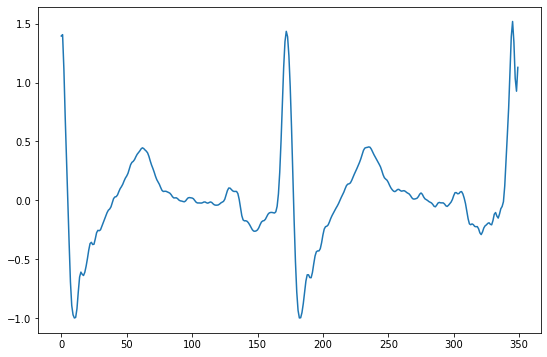

In [35]:
    signal = patches_df_.loc["S001_65"]
    print(signal['label'])
    length = len(signal['first_lead'])
    fig,ax = plt.subplots()
    fig.set_size_inches(9, 6)
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax.plot(x,first_lead)

    
    plt.show()

[0. 1. 0.]


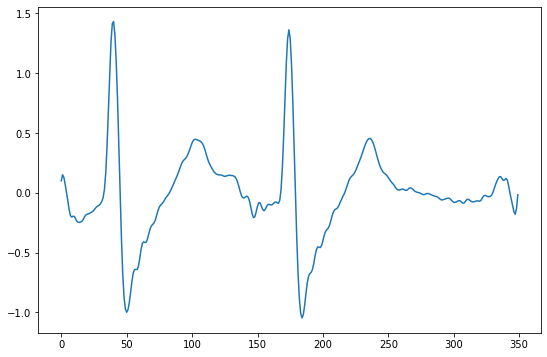

In [36]:
    signal = patches_df_.loc["S001_72"]
    print(signal['label'])
    length = len(signal['first_lead'])
    fig,ax = plt.subplots()
    fig.set_size_inches(9, 6)
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax.plot(x,first_lead)

    
    plt.show()

[0. 0. 1.]


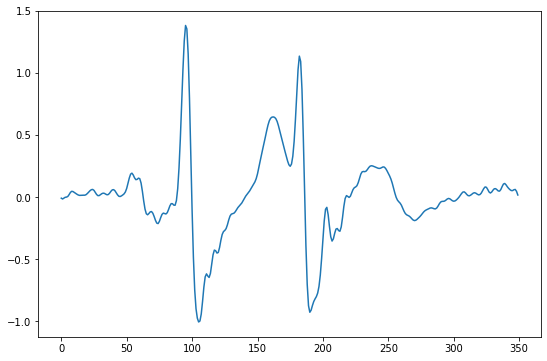

In [37]:
    signal = patches_df_.loc["S001_21"]
    print(signal['label'])
    length = len(signal['first_lead'])
    fig,ax = plt.subplots()
    fig.set_size_inches(9, 6)
  
    
    first_lead = signal['first_lead'][:length]
    second_lead = signal['second_lead'][:length]
    
    x = list(range(length))
    
    ax.plot(x,first_lead)

    
    plt.show()

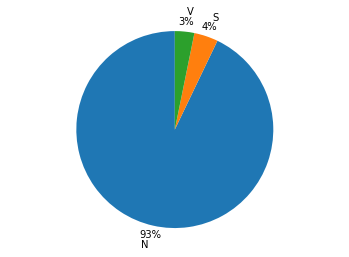

In [49]:
total_labels = patches_df_['stringLabel'].values


classes = ["N","S","V"]

counts = [0]*3


for l in total_labels:
    counts[classes.index(l)] += 1

fig1, ax = plt.subplots()

ax.pie(counts, explode=None, labels=classes, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2,
        shadow=False, startangle=90)
ax.axis('equal')  


fig1.set_facecolor("white")
